## **Perform following Data Pre-processing tasks using python. Data   reduction   using   variance   threshold,   univariate   feature   selection, recursive feature elimination, PCA.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, RFE, SelectFromModel, SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.datasets import load_iris

In [30]:
iris = load_iris()
X = iris.data
y = iris.target

In [31]:
print(X[1, :])
print(X.shape)

[4.9 3.  1.4 0.2]
(150, 4)


In [4]:
# In order to test the effectness of different feature selection methods, we add some noise features to the dataset.
np.random.seed(100)
E = np.random.uniform(0, 1, size=(len(X), 10))
X = np.hstack((X, E))
X.shape

(150, 14)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)
X_train.shape

(120, 14)

### **Variance Thresholding**
*   VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold.
*   By default, it removes all zero-variance features

In [14]:
sel_variance_threshold = VarianceThreshold() 
X_train_remove_variance = sel_variance_threshold.fit_transform(X_train)
X_train_remove_variance.shape
# Variance threshold is applied but since the noise valued columns have non-zero variance, they aren't deleted

(120, 14)

### **Univariate Feature Selection**

*   Univariate feature selection works by selecting the best features based on univariate statistical tests.
*   We compare each feature to the target variable, to see whether there is statistically significant relationship between them.

For regression: f_regression, mutual_info_regression

For classification: chi2, f_classif, mutual_info_classif

In [15]:
# Since this is iris dataset we are working on, we will use classfication techniques
# Analysis Of Variance (ANOVA)
sel_f = SelectKBest(f_classif, k=4)
X_train_f = sel_f.fit_transform(X_train, y_train)

print(sel_f.get_support())
print(sel_f.get_params())

[ True  True  True  True False False False False False False False False
 False False]
{'k': 4, 'score_func': <function f_classif at 0x7ffbbdf76830>}


In [16]:
# Chi2 Test
sel_chi2 = SelectKBest(chi2, k=4) # select 4 features
X_train_chi2 = sel_chi2.fit_transform(X_train, y_train)

print(sel_chi2.get_support())
print(sel_chi2.get_params())

[ True  True  True  True False False False False False False False False
 False False]
{'k': 4, 'score_func': <function chi2 at 0x7ffbbdf76440>}


In [17]:
# mutual_info_classif Test
sel_mutual = SelectKBest(mutual_info_classif, k=4)
X_train_mutual = sel_mutual.fit_transform(X_train, y_train)

print(sel_mutual.get_support())
print(sel_mutual.get_params())

[ True  True  True  True False False False False False False False False
 False False]
{'k': 4, 'score_func': <function mutual_info_classif at 0x7ffbbba00a70>}


### **Recursive Feature Elimination**
*   Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.
*   First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a featureimportances attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.



In [18]:
model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
sel_rfe_tree = RFE(estimator=model_tree, n_features_to_select=4, step=1)
X_train_rfe_tree = sel_rfe_tree.fit_transform(X_train, y_train)
print(sel_rfe_tree.get_support())

[ True  True  True  True False False False False False False False False
 False False]


### **Differences between before and after using Feature Selection**

In [23]:
#Before using Feature Selection
model_logistic = LogisticRegression(multi_class='multinomial', max_iter=1000)
model_logistic.fit(X_train, y_train)
predict = model_logistic.predict(X_test)
print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))

[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.92      0.96        13
           2       0.86      1.00      0.92         6

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



In [24]:
#After using Feature Selection
model_logistic = LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10000)
model_logistic.fit(X_train_f, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
X_test_f = sel_f.transform(X_test)
print(X_test.shape)
print(X_test_f.shape)

(30, 14)
(30, 4)


In [26]:
predict = model_logistic.predict(X_test_f)
print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))

[[11  0  0]
 [ 0 12  1]
 [ 0  0  6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.92      0.96        13
           2       0.86      1.00      0.92         6

    accuracy                           0.97        30
   macro avg       0.95      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30



### **PCA**
Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. Although, all features in the Iris dataset were measured in centimeters, let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
x = StandardScaler().fit_transform(X)
features = ['sepal length', 'sepal width', 'petal length', 'petal width']

In [34]:
pd.DataFrame(data = x, columns = features).head()

,sepal length,sepal width,petal length,petal width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


In [35]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf.head(5)

,principal component 1,principal component 2
0,-2.264703,0.480027
1,-2.080961,-0.674134
2,-2.364229,-0.341908
3,-2.299384,-0.597395
4,-2.389842,0.646835


In [36]:
# Getting Target variable from the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])
y = df.loc[:,['target']].values
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
finalDf.head(5)

,principal component 1,principal component 2,target
0,-2.264703,0.480027,Iris-setosa
1,-2.080961,-0.674134,Iris-setosa
2,-2.364229,-0.341908,Iris-setosa
3,-2.299384,-0.597395,Iris-setosa
4,-2.389842,0.646835,Iris-setosa


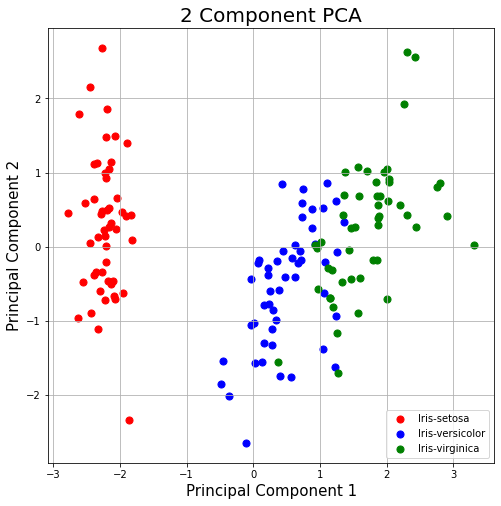

In [39]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [38]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf1 = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2','principal component 3'])
finalDf1 = pd.concat([principalDf1, df[['target']]], axis = 1)
finalDf1.head(5)

,principal component 1,principal component 2,principal component 3,target
0,-2.264703,0.480027,-0.127706,Iris-setosa
1,-2.080961,-0.674134,-0.234609,Iris-setosa
2,-2.364229,-0.341908,0.044201,Iris-setosa
3,-2.299384,-0.597395,0.091290,Iris-setosa
4,-2.389842,0.646835,0.015738,Iris-setosa


In [42]:
import plotly.express as px
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'b', 'g']
fig = px.scatter_3d(finalDf1,x="principal component 1",y="principal component 2",z="principal component 3",color="target")
fig.show()